# Requirements

In [1]:
!pip install matplotlib==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install hazm
!pip install stopwords_guilannlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 16.6 MB/s 
     |████████████████████████████████| 1.4 MB 54.3 MB/s 
     |████████████████████████████████| 233 kB 36.5 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=a265031f2b1f9e5c1fb743f8b606ebf88858c210cb741ebfaef12335cd16c922
  Stored in directory: /root/.cache/pip/wheels/19/1d/3a/0a8c14c30132b4f9ffd796efbb6746f15b3d6bcfc1055a9346
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp38-cp38-linux_x86_64.whl size=154929 sha256=e3f1b7d2522d7672ce3df8f0936603fad6ca6c81f71e7876d2e35474b918c06d
  Stored in directory: /root/.cache/pip/wheels/3c/d8/9f/59fd78b2b7d1e9ffcb68fb6de80c2e7c20b804c8cbc4d8fc23
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get FastText

Download FastText word vectors file for Persian

(The list of all model vector files are available [here](https://fasttext.cc/docs/en/pretrained-vectors.html))

In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec

--2022-12-27 20:46:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fa.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105157170 (1.0G) [binary/octet-stream]
Saving to: ‘wiki.fa.vec’

wiki.fa.vec         100%[===================>]   1.03G  17.1MB/s    in 65s     

2022-12-27 20:47:53 (16.3 MB/s) - ‘wiki.fa.vec’ saved [1105157170/1105157170]



In [25]:
import numpy as np
import pandas as pd
import codecs
from google.colab import files

from gensim.models import KeyedVectors
import gensim

from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Embedding, Dropout
from keras.layers import GlobalMaxPool1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import CuDNNLSTM, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.utils.np_utils import to_categorical
from keras.metrics import categorical_accuracy
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from stopwords_guilannlp import stopwords_output
from hazm import *

import matplotlib.pyplot as plt
from keras.utils import plot_model

from sklearn.metrics import f1_score

In [8]:
uploaded = files.upload()

Saving df.csv to df.csv



# Import & Analyze Dataset

In [9]:
df = pd.read_csv('df.csv', index_col=None, header=None, encoding="utf-8")
#balanced = pd.read_csv('balanced.csv', index_col=None, header=None, encoding="utf-8")
#translation = pd.read_csv('translation.csv', index_col=None, header=None, encoding="utf-8")

In [10]:
temp = df[[3,1]]
temp = temp.drop(temp.index[0])

In [11]:
temp = temp.sample(frac=1)

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp, test_size=0.1)

In [14]:
x_test = np.asarray(test[3])
y_test = np.asarray(test[1])

In [15]:
train = train.sample(frac=1).reset_index(drop=True)

In [16]:
x_train = train[3]
y_train = train[1]

In [17]:
print('Number of training sentence: ', x_train.shape)
print('Number of training label: ', y_train.shape)

Number of training sentence:  (8161,)
Number of training label:  (8161,)


In [18]:
# Convert dataframes to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [19]:
# See the data number of sentence in each category 
from collections import Counter
cnt = Counter(y_train)
cnt = dict(cnt)
print(cnt)

{'1': 2720, '0': 2728, '2': 2713}


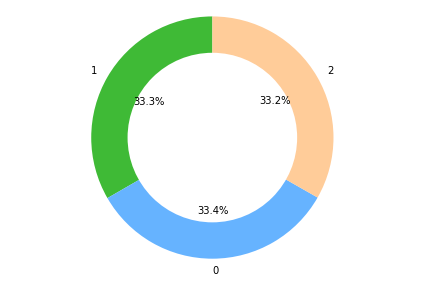

In [20]:
labels = list(cnt.keys())
sizes = list(cnt.values())
colors = ['#3fba36', '#66b3ff','#ffcc99','#ff9999', '#d44444']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# Decomment following line if you want to save the figure
# plt.savefig('distribution.png')
plt.show()

In [ ]:
# Decomment following line if you want to download dataset figure
# files.download('distribution.png')

# Preprocess

In [21]:
puncs = ['،', '.', ',', ':', ';', '"']
normalizer = Normalizer()
lemmatizer = Lemmatizer()

# turn a doc into clean tokens
def clean_doc(doc):
    doc = normalizer.normalize(doc) # Normalize document using Hazm Normalizer
    tokenized = word_tokenize(doc)  # Tokenize text
    tokens = []
    for t in tokenized:
      temp = t
      for p in puncs:
        temp = temp.replace(p, '')
      tokens.append(temp)
    # tokens = [w for w in tokens if not w in stop_set]    # Remove stop words
    tokens = [w for w in tokens if not len(w) <= 1]
    tokens = [w for w in tokens if not w.isdigit()]
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # Lemmatize sentence words using Hazm Lemmatizer
    tokens = ' '.join(tokens)
    return tokens

# FastText Model

In [42]:
EMBEDDING_FILE = 'wiki.fa.vec'

def import_with_gensim(file_address):
  # Creating the model
  ft_model = KeyedVectors.load_word2vec_format(file_address)
  # Getting the tokens
  ft_words = []
  for ft_word in ft_model.vocab:
      ft_words.append(ft_word)
  return ft_model, ft_words
  
ft_model, ft_words = import_with_gensim(EMBEDDING_FILE)

In [30]:
# Save:
df = pd.DataFrame(ft_words)
df.to_csv('ft_words.csv')
ft_model.save_word2vec_format('ft_model.bin', binary=True)

In [35]:
# Load:
ft_words = pd.read_csv('ft_words.csv').values.tolist()
ft_moldel2 = gensim.models.KeyedVectors.load_word2vec_format('ft_model.bin', binary=True)

In [34]:
# FastText embedding dimensionality
embed_size = 300

In [43]:
# We get the mean and standard deviation of the embedding weights so that we could maintain the
# same statistics for the rest of our own random generated weights.
embedding_list = list()
for w in ft_words:
  embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

## preprocessing:

In [44]:
# Apply preprocessing step to training data
train_docs = np.empty_like(x_train)
for index, document in enumerate(x_train):
  train_docs[index] = clean_doc(document)

In [45]:
# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_doc(document)

## Setting tokenizer up:

In [46]:
num_words = 2000

# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)

# fFt the tokenizer on the training documents
tokenizer.fit_on_texts(train_docs)

In [47]:
# Find maximum length of training sentences
max_length = max([len(s.split()) for s in train_docs])

## Embed sentences:

In [48]:
# Embed training sequences
encoded_docs = tokenizer.texts_to_sequences(train_docs)

# Pad embeded training sequences
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [49]:
# Define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index)

In [50]:
# We are going to set the embedding size to the pre-trained dimension as we are replicating it
nb_words = len(tokenizer.word_index)

# the size will be Number of Words in Vocab X Embedding Size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

# With the newly created embedding matrix, we'll fill it up with the words that we have in both
# our own dictionary and loaded pre-trained embedding.
embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i -= 1
    # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
    if word in ft_model.vocab:
        embedding_vector = ft_model[word]
        # and store inside the embedding matrix that we will train later on.
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:   # Unknown words
        embedding_vector = ft_model['subdivision_name']
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

total embedded: 2495 common words
Embedding matrix shape: (2495, 300)


In [51]:
# Embed testing sequences
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# Pad testing sequences
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

# Deep Learning Models:

In [53]:
# Prepare labels for categorical prediction
categorical_y_train = to_categorical(y_train, 3)
categorical_y_test = to_categorical(y_test, 3)

## B-LSTM Model:

In [55]:
model_blstm = Sequential()
model_blstm.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_blstm.add(Bidirectional(CuDNNLSTM(300, return_sequences=True, name='lstm_layer')))
model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.1))
model_blstm.add(Dense(3, activation='softmax'))

In [56]:
model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 5

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         748500    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 600)        1444800   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 600)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 600)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               180300    
                                                                 
 dropout_3 (Dropout)         (None, 300)              

In [57]:
# Train model
hist_blstm = model_blstm.fit(x_train_padded, categorical_y_train, batch_size=batch_size_blstm, epochs=epochs_blstm, shuffle=True)

Epoch 1/5
128/128 [==============================] - 9s 17ms/step - loss: 0.7436 - categorical_accuracy: 0.6465
Epoch 2/5
128/128 [==============================] - 3s 20ms/step - loss: 0.3127 - categorical_accuracy: 0.8852
Epoch 3/5
128/128 [==============================] - 2s 16ms/step - loss: 0.1922 - categorical_accuracy: 0.9273
Epoch 4/5
128/128 [==============================] - 2s 14ms/step - loss: 0.1451 - categorical_accuracy: 0.9416
Epoch 5/5
128/128 [==============================] - 2s 18ms/step - loss: 0.1184 - categorical_accuracy: 0.9533


In [66]:
# Evaluate model
loss_blstm, acc_blstm = model_blstm.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_blstm*100))

Test Accuracy: 88.092613


In [60]:
# Save the Model:
model_blstm.save("BLSTM_model.h5")

In [65]:
# load the Model:
from keras.models import load_model

model_blstm = load_model('BLSTM_model.h5')

In [109]:
# Get prediction label
preds = model_blstm.predict(x_test_padded)
y_pred_blstm = np.argmax(preds, axis=1)

29/29 [==============================] - 2s 56ms/step


## CNN Model:

In [68]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, embedding_matrix.shape[1], weights=[embedding_matrix], trainable=True))
model_cnn.add(Conv1D(filters=64, kernel_size=4, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=8, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=64, kernel_size=16, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(500, activation="sigmoid"))
model_cnn.add(Dense(3, activation='softmax'))

In [69]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

model_cnn.summary()
batch_size_cnn = 64
epochs_cnn = 8

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         748500    
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          76864     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32832     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 64)         

In [70]:
# Train model
hist_cnn = model_cnn.fit(x_train_padded, categorical_y_train, batch_size=batch_size_cnn, epochs=epochs_cnn, shuffle=True)

Epoch 1/8
128/128 [==============================] - 9s 33ms/step - loss: 0.9067 - categorical_accuracy: 0.5187
Epoch 2/8
128/128 [==============================] - 1s 7ms/step - loss: 0.3710 - categorical_accuracy: 0.8587
Epoch 3/8
128/128 [==============================] - 2s 13ms/step - loss: 0.2004 - categorical_accuracy: 0.9253
Epoch 4/8
128/128 [==============================] - 4s 32ms/step - loss: 0.1381 - categorical_accuracy: 0.9466
Epoch 5/8
128/128 [==============================] - 2s 17ms/step - loss: 0.1049 - categorical_accuracy: 0.9561
Epoch 6/8
128/128 [==============================] - 1s 9ms/step - loss: 0.0922 - categorical_accuracy: 0.9602
Epoch 7/8
128/128 [==============================] - 1s 8ms/step - loss: 0.0776 - categorical_accuracy: 0.9643
Epoch 8/8
128/128 [==============================] - 2s 14ms/step - loss: 0.0690 - categorical_accuracy: 0.9684


In [75]:
# Evaluate model
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_padded, categorical_y_test, verbose=0)
print('Test Accuracy: %f' % (acc_cnn*100))

Test Accuracy: 89.084893


In [72]:
# Save the Model:
model_cnn.save("CNN_model.h5")

In [73]:
# load the Model:
from keras.models import load_model

model_cnn = load_model('CNN_model.h5')

In [88]:
# Get prediction label
preds = model_cnn.predict(x_test_padded)
y_pred_cnn = np.argmax(preds, axis=1)

29/29 [==============================] - 0s 2ms/step


# Confusion Matrix:

In [94]:
import tensorflow as tf

confusion = tf.math.confusion_matrix(labels= y_test_label, predictions=y_pred_cnn, num_classes=3)
print(confusion)

tf.Tensor(
[[259  26   9]
 [ 47 247   9]
 [  3   5 302]], shape=(3, 3), dtype=int32)


In [ ]:
!pip install pretty-confusion-matrix

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

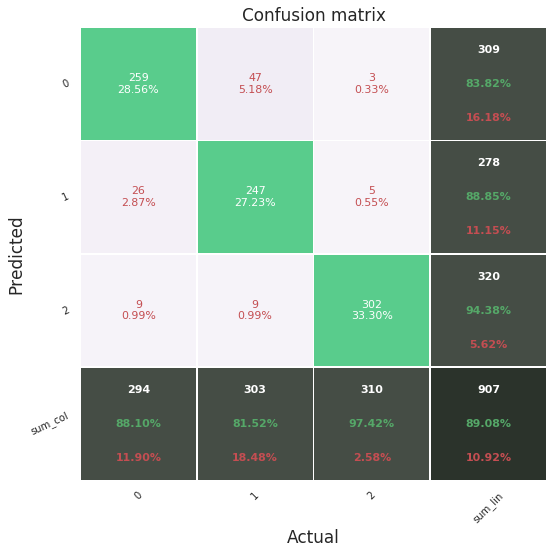

In [104]:
from pretty_confusion_matrix import pp_matrix

confusion = np.asarray(confusion, np.int32)
df_cm = pd.DataFrame(confusion, index=range(3), columns=range(3))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [110]:
confusion = tf.math.confusion_matrix(labels= y_test_label, predictions=y_pred_blstm, num_classes=3)
print(confusion)

tf.Tensor(
[[240  35  19]
 [ 32 264   7]
 [  3  12 295]], shape=(3, 3), dtype=int32)


/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

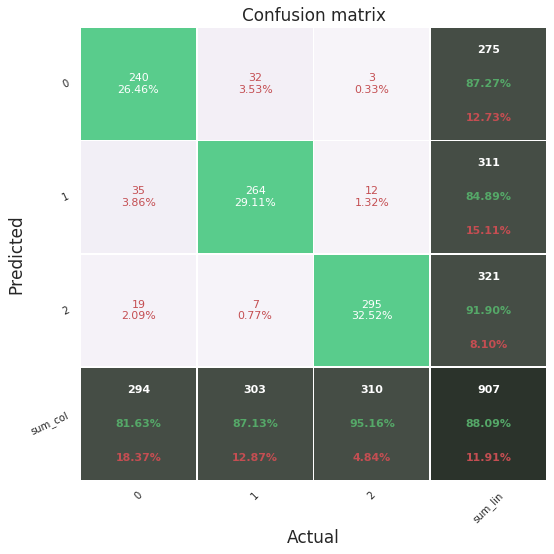

In [111]:
from pretty_confusion_matrix import pp_matrix

confusion = np.asarray(confusion, np.int32)
df_cm = pd.DataFrame(confusion, index=range(3), columns=range(3))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

## F1 Score:

In [105]:
print("(Weighted) F1 score of FastTextEmb B-LSTM model:")
f1_score(y_test_label, y_pred_blstm, average='weighted')

(Weighted) F1 score of FastTextEmb B-LSTM model:


ValueError: ignored

In [ ]:
print("(Weighted) F1 score of FastTextEmb CNN model:")
f1_score(y_test_label, y_pred_cnn, average='weighted')



(Weighted) F1 score of FastTextEmb CNN model:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6156481328277128